# Week 5 Image Feature Extraction — Brazil

This notebook extracts country–year features from annual GeoTIFFs (VIIRS nightlights + population) using a tile-based pipeline designed to handle very large rasters without freezing.


In [1]:
import os, glob, re, math
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

# === USER PATH ===
DATA_PATH = r"C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil"
COUNTRY = "Brazil"
YEARS = list(range(2014, 2024))

# Outputs
OUTPUT_DIR = os.path.join(DATA_PATH, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# GeoTIFF discovery (search in country subfolder first; fall back to root)
def list_country_tifs(country):
    patterns = [
        os.path.join(DATA_PATH, country, f"{country}_*.tif"),
        os.path.join(DATA_PATH, f"{country}_*.tif"),
    ]
    files = []
    for p in patterns:
        files.extend(glob.glob(p))
    return sorted(set(files))

tifs = list_country_tifs(COUNTRY)
years_found = sorted([int(re.findall(r"_(\d{4})", os.path.basename(f))[0]) for f in tifs]) if tifs else []
print("Country:", COUNTRY)
print("TIFs found:", len(tifs))
print("Years found:", years_found)
if tifs:
    print("Example file:", os.path.basename(tifs[0]))


Country: Brazil
TIFs found: 10
Years found: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Example file: Brazil_2014.tif


## Helpers: safe window reading + adaptive tiling

In [2]:
def _read_band_window(ds, band_index, window):
    """Read a band for a rasterio dataset in a window as float32 with nodata -> NaN."""
    a = ds.read(band_index, window=window, masked=True).astype("float32")
    if hasattr(a, "filled"):
        a = a.filled(np.nan)
    return a

def choose_tile_size(height, width, target_tiles=4000, min_size=128, max_size=1024):
    """Pick a tile size so the grid has ~target_tiles tiles (bounded)."""
    total_px = float(height) * float(width)
    tile_px = max(1.0, total_px / float(target_tiles))
    size = int(round(math.sqrt(tile_px)))
    size = max(min_size, min(max_size, size))
    return max(1, size)

def windows_for_shape(height, width, tile_size):
    """Yield rasterio windows covering the raster."""
    from rasterio.windows import Window
    for r0 in range(0, height, tile_size):
        for c0 in range(0, width, tile_size):
            h = min(tile_size, height - r0)
            w = min(tile_size, width - c0)
            yield (r0, c0), Window(c0, r0, w, h)

def gini_from_hist(counts, bin_edges):
    """Approximate Gini from histogram (counts over bins with edges)."""
    counts = np.asarray(counts, dtype=np.float64)
    if counts.sum() <= 0:
        return np.nan
    mids = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    order = np.argsort(mids)
    x = mids[order]
    w = counts[order]
    W = w.sum()
    mu = (w * x).sum() / W
    if mu == 0:
        return 0.0
    cw = np.cumsum(w) / W
    cwx = np.cumsum(w * x) / (W * mu)
    B = np.trapz(cwx, cw)
    return float(1.0 - 2.0 * B)

def hist_quantile(counts, bin_edges, q):
    """Approximate quantile from histogram."""
    counts = np.asarray(counts, dtype=np.float64)
    if counts.sum() <= 0:
        return np.nan
    cum = np.cumsum(counts)
    target = q * cum[-1]
    idx = int(np.searchsorted(cum, target, side="left"))
    idx = max(0, min(idx, len(bin_edges) - 2))
    return float(bin_edges[idx+1])

def safe_corr(x, y):
    """Correlation with guards to avoid warnings (needs >=3 and std>0)."""
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]; y = y[m]
    if x.size < 3:
        return np.nan
    sx = np.std(x); sy = np.std(y)
    if sx == 0 or sy == 0:
        return np.nan
    return float(np.corrcoef(x, y)[0, 1])


## Core feature extraction (tile-based, two-pass)

In [3]:
def tif_path(country, year):
    fp1 = os.path.join(DATA_PATH, country, f"{country}_{year}.tif")
    fp2 = os.path.join(DATA_PATH, f"{country}_{year}.tif")
    if os.path.exists(fp1):
        return fp1
    if os.path.exists(fp2):
        return fp2
    return None

def extract_features_for_year(country, year, scatter_sample_max=40000, pop_q_sample_max=250000):
    fp = tif_path(country, year)
    if fp is None:
        return None

    with rasterio.open(fp) as ds:
        H, W = ds.height, ds.width
        tile_size = choose_tile_size(H, W, target_tiles=4000, min_size=128, max_size=1024)
        grid_h = int(math.ceil(H / tile_size))
        grid_w = int(math.ceil(W / tile_size))

        # PASS 1: global aggregates + samples + NL histogram in log1p space
        nl_log_bins = np.linspace(0.0, 10.0, 1001)
        nl_log_counts = np.zeros(len(nl_log_bins) - 1, dtype=np.int64)

        area_pixels = 0
        nl_sum = 0.0
        nl_sumsq = 0.0
        pop_sum = 0.0

        pop_log_sample_parts = []
        scatter_pop_log_parts = []
        scatter_nl_log_parts = []

        rng = np.random.default_rng(42 + year)

        for (r0c0, win) in windows_for_shape(H, W, tile_size):
            nl = _read_band_window(ds, 1, win)
            pop = _read_band_window(ds, 2, win)

            m = np.isfinite(nl) & np.isfinite(pop)
            if not np.any(m):
                continue

            nl_v = nl[m]
            pop_v = pop[m]

            area_pixels += int(nl_v.size)
            nl_sum += float(np.nansum(nl_v))
            nl_sumsq += float(np.nansum(nl_v * nl_v))
            pop_sum += float(np.nansum(pop_v))

            nl_pos = nl_v[nl_v > 0]
            if nl_pos.size:
                nl_log = np.log1p(nl_pos)
                nl_log_counts += np.histogram(nl_log, bins=nl_log_bins)[0]

            # pop quantile sample (log1p)
            pop_pos = pop_v[pop_v > 0]
            if pop_pos.size:
                pop_log = np.log1p(pop_pos)
                take = min(2000, pop_log.size)
                idx = rng.choice(pop_log.size, size=take, replace=False) if pop_log.size > take else np.arange(pop_log.size)
                pop_log_sample_parts.append(pop_log[idx])

            # scatter sample pieces
            take = min(1500, nl_v.size)
            idx = rng.choice(nl_v.size, size=take, replace=False) if nl_v.size > take else np.arange(nl_v.size)
            scatter_pop_log_parts.append(np.log1p(np.maximum(pop_v[idx], 0)))
            scatter_nl_log_parts.append(np.log1p(np.maximum(nl_v[idx], 0)))

        if area_pixels == 0:
            return None

        pop_log_sample = np.concatenate(pop_log_sample_parts) if pop_log_sample_parts else np.array([], dtype=np.float32)
        if pop_log_sample.size > pop_q_sample_max:
            idx = rng.choice(pop_log_sample.size, size=pop_q_sample_max, replace=False)
            pop_log_sample = pop_log_sample[idx]

        scatter_pop_log = np.concatenate(scatter_pop_log_parts) if scatter_pop_log_parts else np.array([], dtype=np.float32)
        scatter_nl_log = np.concatenate(scatter_nl_log_parts) if scatter_nl_log_parts else np.array([], dtype=np.float32)
        if scatter_pop_log.size > scatter_sample_max:
            idx = rng.choice(scatter_pop_log.size, size=scatter_sample_max, replace=False)
            scatter_pop_log = scatter_pop_log[idx]
            scatter_nl_log = scatter_nl_log[idx]

        mean_light = nl_sum / area_pixels
        var_light = max(0.0, nl_sumsq / area_pixels - mean_light * mean_light)
        std_light = math.sqrt(var_light)

        nl_log_p90 = hist_quantile(nl_log_counts, nl_log_bins, 0.90)
        lit_threshold_p90 = float(np.expm1(nl_log_p90)) if np.isfinite(nl_log_p90) else np.nan

        nl_bins = np.expm1(nl_log_bins)
        gini_light_pos = gini_from_hist(nl_log_counts, nl_bins)

        if pop_log_sample.size >= 10:
            q = np.quantile(pop_log_sample, [0.2, 0.4, 0.6, 0.8])
        else:
            q = np.array([0.5, 1.0, 2.0, 3.0], dtype=float)

        # PASS 2: tail + pop-bin shares + tile summaries
        lit_px = 0
        lit_light_mass = 0.0

        bin_light = np.zeros(5, dtype=np.float64)
        total_light_mass_pos = 0.0

        tile_rows = []
        tile_pop_mean = np.full((grid_h, grid_w), np.nan, dtype=np.float32)
        tile_nl_mean = np.full((grid_h, grid_w), np.nan, dtype=np.float32)
        tile_corr = np.full((grid_h, grid_w), np.nan, dtype=np.float32)

        for (r0c0, win) in windows_for_shape(H, W, tile_size):
            (r0, c0) = r0c0
            gi = r0 // tile_size
            gj = c0 // tile_size

            nl = _read_band_window(ds, 1, win)
            pop = _read_band_window(ds, 2, win)
            m = np.isfinite(nl) & np.isfinite(pop)
            if not np.any(m):
                continue
            nl_v = nl[m]
            pop_v = pop[m]

            nl_use = np.maximum(nl_v, 0)
            pop_use = np.maximum(pop_v, 0)

            # Positive-only total light mass for stability
            total_light_mass_pos += float(np.sum(nl_use))

            # Tail (p90)
            if np.isfinite(lit_threshold_p90):
                tail = nl_v >= lit_threshold_p90
                if np.any(tail):
                    lit_px += int(np.sum(tail))
                    lit_light_mass += float(np.sum(nl_use[tail]))

            # Pop bins by log1p(pop)
            pop_log = np.log1p(pop_use)
            b = np.digitize(pop_log, q, right=True)  # 0..4
            for k in range(5):
                mk = (b == k)
                if np.any(mk):
                    bin_light[k] += float(np.sum(nl_use[mk]))

            # Tile summaries
            nl_mean = float(np.mean(nl_use))
            pop_mean = float(np.mean(pop_use))
            tile_nl_mean[gi, gj] = nl_mean
            tile_pop_mean[gi, gj] = pop_mean

            take = min(5000, nl_v.size)
            idx = rng.choice(nl_v.size, size=take, replace=False) if nl_v.size > take else np.arange(nl_v.size)
            corr = safe_corr(pop_use[idx], nl_use[idx])
            tile_corr[gi, gj] = corr

            tile_rows.append({
                "tile_i": int(gi), "tile_j": int(gj),
                "tile_pop_mean": pop_mean,
                "tile_nl_mean": nl_mean,
                "tile_corr": float(corr) if np.isfinite(corr) else np.nan,
                "tile_px": int(nl_v.size),
            })

        lit_fraction_p90 = (lit_px / area_pixels) if area_pixels else np.nan
        light_mass_lit_p90 = (lit_light_mass / total_light_mass_pos) if total_light_mass_pos > 0 else np.nan

        bin_share = (bin_light / bin_light.sum()) if bin_light.sum() > 0 else np.full(5, np.nan)

        pop_vals = tile_pop_mean[np.isfinite(tile_pop_mean)]
        nl_vals = tile_nl_mean[np.isfinite(tile_nl_mean)]
        pop_q25, pop_q50, pop_q75 = (np.quantile(pop_vals, [0.25, 0.50, 0.75]) if pop_vals.size >= 10 else (np.nan, np.nan, np.nan))
        nl_q25, nl_q50, nl_q75 = (np.quantile(nl_vals, [0.25, 0.50, 0.75]) if nl_vals.size >= 10 else (np.nan, np.nan, np.nan))

        region_grid = np.zeros((grid_h, grid_w), dtype=np.int8)

        def classify(pop_mean, nl_mean):
            if not (np.isfinite(pop_mean) and np.isfinite(nl_mean)):
                return 0
            if np.isfinite(pop_q25) and np.isfinite(nl_q25) and pop_mean <= pop_q25 and nl_mean <= nl_q25:
                return 0  # empty_or_rural
            if np.isfinite(pop_q75) and np.isfinite(nl_q75) and pop_mean >= pop_q75 and nl_mean >= nl_q75:
                return 4  # urban_core
            if np.isfinite(pop_q75) and np.isfinite(nl_q25) and pop_mean >= pop_q75 and nl_mean <= nl_q25:
                return 3  # dense_dim
            if np.isfinite(pop_q25) and np.isfinite(nl_q75) and pop_mean <= pop_q25 and nl_mean >= nl_q75:
                return 2  # bright_sparse
            return 1      # mixed

        for i in range(grid_h):
            for j in range(grid_w):
                region_grid[i, j] = classify(tile_pop_mean[i, j], tile_nl_mean[i, j])

        valid_tiles = np.isfinite(tile_pop_mean) & np.isfinite(tile_nl_mean)
        n_valid_tiles = int(np.sum(valid_tiles))
        shares = {k: float(np.sum((region_grid == k) & valid_tiles) / n_valid_tiles) for k in [0,1,2,3,4]} if n_valid_tiles else {k: np.nan for k in [0,1,2,3,4]}

        reg_mean_corr_nl_pop = float(np.nanmean(tile_corr)) if np.isfinite(tile_corr).any() else np.nan
        reg_std_region_mean_nl = float(np.nanstd(tile_nl_mean)) if np.isfinite(tile_nl_mean).any() else np.nan

        features = {
            "country": country,
            "year": int(year),
            "height": int(H),
            "width": int(W),
            "tile_size": int(tile_size),
            "grid_h": int(grid_h),
            "grid_w": int(grid_w),

            "area_pixels": int(area_pixels),
            "total_light_mass": float(total_light_mass_pos),
            "mean_light": float(mean_light),
            "std_light": float(std_light),

            "gini_light_pos": float(gini_light_pos) if np.isfinite(gini_light_pos) else np.nan,

            "lit_threshold_p90": float(lit_threshold_p90) if np.isfinite(lit_threshold_p90) else np.nan,
            "lit_fraction_p90": float(lit_fraction_p90) if np.isfinite(lit_fraction_p90) else np.nan,
            "light_mass_lit_p90": float(light_mass_lit_p90) if np.isfinite(light_mass_lit_p90) else np.nan,

            "pop_mass": float(pop_sum),
            "light_per_pop": float(total_light_mass_pos / pop_sum) if pop_sum > 0 else np.nan,

            "light_share_very_low": float(bin_share[0]),
            "light_share_low": float(bin_share[1]),
            "light_share_medium": float(bin_share[2]),
            "light_share_high": float(bin_share[3]),
            "light_share_very_high": float(bin_share[4]),

            "reg_mean_corr_nl_pop": float(reg_mean_corr_nl_pop) if np.isfinite(reg_mean_corr_nl_pop) else np.nan,
            "reg_std_region_mean_nl": float(reg_std_region_mean_nl) if np.isfinite(reg_std_region_mean_nl) else np.nan,

            "region_share_empty_or_rural": float(shares[0]),
            "region_share_mixed": float(shares[1]),
            "region_share_bright_sparse": float(shares[2]),
            "region_share_dense_dim": float(shares[3]),
            "region_share_urban_core": float(shares[4]),
        }

        tile_df = pd.DataFrame(tile_rows)
        return features, region_grid, tile_df, (scatter_pop_log, scatter_nl_log)


## Run extraction for all years

In [4]:
features_list = []
region_grids = {}
tile_tables = {}
scatter_latest = None

years_available = [y for y in YEARS if tif_path(COUNTRY, y) is not None]
print("Available years:", years_available)

for y in years_available:
    print(f"Processing {COUNTRY} {y} ...")
    out = extract_features_for_year(COUNTRY, y, scatter_sample_max=40000, pop_q_sample_max=250000)
    if out is None:
        print("  -> skipped (missing or empty)")
        continue
    feat, grid, tile_df, scatter = out
    features_list.append(feat)
    region_grids[y] = grid
    tile_tables[y] = tile_df
    scatter_latest = scatter

features_df = pd.DataFrame(features_list).sort_values("year").reset_index(drop=True)
features_df


Available years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Processing Brazil 2014 ...


C:\Users\BOUCHRA\AppData\Local\Temp\ipykernel_36852\888873203.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  B = np.trapz(cwx, cw)


Processing Brazil 2015 ...
Processing Brazil 2016 ...
Processing Brazil 2017 ...
Processing Brazil 2018 ...
Processing Brazil 2019 ...
Processing Brazil 2020 ...
Processing Brazil 2021 ...
Processing Brazil 2022 ...
Processing Brazil 2023 ...


,country,year,height,width,tile_size,grid_h,grid_w,area_pixels,total_light_mass,mean_light,...,light_share_medium,light_share_high,light_share_very_high,reg_mean_corr_nl_pop,reg_std_region_mean_nl,region_share_empty_or_rural,region_share_mixed,region_share_bright_sparse,region_share_dense_dim,region_share_urban_core
0,Brazil,2014,8689,10051,148,59,68,35075064,8.842500e+06,0.248000,...,0.035797,0.062588,0.773552,0.449612,1.257028,0.159520,0.619211,0.000572,0.0,0.220698
1,Brazil,2015,8689,10051,148,59,68,35075064,9.132672e+06,0.258903,...,0.039190,0.064748,0.729844,0.439671,1.149246,0.154374,0.622070,0.000572,0.0,0.222985
2,Brazil,2016,8689,10051,148,59,68,35075065,8.062470e+06,0.223077,...,0.030222,0.056467,0.816984,0.453010,1.179420,0.170383,0.608348,0.000572,0.0,0.220698
3,Brazil,2017,8689,10051,148,59,68,35075067,1.476044e+07,0.420824,...,0.053499,0.078941,0.517792,0.464625,1.190469,0.140080,0.634648,0.000572,0.0,0.224700
4,Brazil,2018,8689,10051,148,59,68,35075405,1.443266e+07,0.411475,...,0.051604,0.076781,0.526833,0.480114,1.171814,0.150372,0.620354,0.000000,0.0,0.229274
5,Brazil,2019,8689,10051,148,59,68,35075664,1.317768e+07,0.375693,...,0.046478,0.075428,0.568377,0.467658,1.164897,0.148085,0.624929,0.000572,0.0,0.226415
6,Brazil,2020,8689,10051,148,59,68,35075789,1.607774e+07,0.458371,...,0.054151,0.084849,0.470596,0.461542,1.085566,0.165237,0.608919,0.001144,0.0,0.224700
7,Brazil,2021,8689,10051,148,59,68,35075791,1.597593e+07,0.455469,...,0.054809,0.087174,0.479038,0.455052,1.103658,0.134362,0.643225,0.000000,0.0,0.222413
8,Brazil,2022,8689,10051,148,59,68,35075831,1.663304e+07,0.474202,...,0.054002,0.089502,0.474085,0.456483,1.132637,0.141795,0.633505,0.000000,0.0,0.224700
9,Brazil,2023,8689,10051,148,59,68,35075831,1.868907e+07,0.532819,...,0.056176,0.086381,0.479299,0.521048,1.232560,0.149228,0.627216,0.000572,0.0,0.222985


## Save feature table

In [5]:
out_csv = os.path.join(OUTPUT_DIR, "Brazil_features_country_year.csv")
features_df.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Saved: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil\outputs\Brazil_features_country_year.csv


## Figures

In [6]:
def savefig(name):
    fp = os.path.join(OUTPUT_DIR, name)
    plt.savefig(fp, dpi=150, bbox_inches="tight")
    print("Saved figure:", fp)
    plt.close()

# 1) Fast region typology maps (tile grid via imshow) for selected years
selected_years = [yy for yy in [2014, 2017, 2020, 2023] if yy in region_grids]
label_names = {
    0: "empty_or_rural",
    1: "mixed",
    2: "bright_sparse",
    3: "dense_dim",
    4: "urban_core",
}

for yy in selected_years:
    grid = region_grids[yy]
    plt.figure(figsize=(8, 6))
    plt.imshow(grid, interpolation="nearest")
    plt.title(f"{COUNTRY} {yy} — region typology (tile grid)")
    plt.xlabel("tile column")
    plt.ylabel("tile row")
    cbar = plt.colorbar(ticks=list(label_names.keys()))
    cbar.ax.set_yticklabels([label_names[k] for k in label_names.keys()])
    savefig(f"Brazil_region_typology_{yy}.png")

# 2) Sampled pixel scatter for latest year processed
if scatter_latest is not None and scatter_latest[0].size:
    x = scatter_latest[0]
    y = scatter_latest[1]
    plt.figure(figsize=(7, 6))
    plt.scatter(x, y, s=4, alpha=0.25)
    plt.xlabel("log(1 + population)")
    plt.ylabel("log(1 + nightlights)")
    plt.title(f"{COUNTRY} — sampled pixels (latest year)")
    savefig(f"Brazil_scatter_latest_year.png")

# 3) Time-series of total_light_mass
if not features_df.empty:
    plt.figure(figsize=(7, 4))
    plt.plot(features_df["year"], features_df["total_light_mass"], marker="o")
    plt.xlabel("Year")
    plt.ylabel("Total light mass (sum of positive nightlights)")
    plt.title(f"{COUNTRY} — total_light_mass over time")
    savefig(f"Brazil_total_light_mass_timeseries.png")


Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil\outputs\Brazil_region_typology_2014.png
Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil\outputs\Brazil_region_typology_2017.png
Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil\outputs\Brazil_region_typology_2020.png
Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil\outputs\Brazil_region_typology_2023.png
Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil\outputs\Brazil_scatter_latest_year.png
Saved figure: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil\outputs\Brazil_total_light_mass_timeseries.png


## Final feature table (for screenshot)

In [7]:
features_df

,country,year,height,width,tile_size,grid_h,grid_w,area_pixels,total_light_mass,mean_light,...,light_share_medium,light_share_high,light_share_very_high,reg_mean_corr_nl_pop,reg_std_region_mean_nl,region_share_empty_or_rural,region_share_mixed,region_share_bright_sparse,region_share_dense_dim,region_share_urban_core
0,Brazil,2014,8689,10051,148,59,68,35075064,8.842500e+06,0.248000,...,0.035797,0.062588,0.773552,0.449612,1.257028,0.159520,0.619211,0.000572,0.0,0.220698
1,Brazil,2015,8689,10051,148,59,68,35075064,9.132672e+06,0.258903,...,0.039190,0.064748,0.729844,0.439671,1.149246,0.154374,0.622070,0.000572,0.0,0.222985
2,Brazil,2016,8689,10051,148,59,68,35075065,8.062470e+06,0.223077,...,0.030222,0.056467,0.816984,0.453010,1.179420,0.170383,0.608348,0.000572,0.0,0.220698
3,Brazil,2017,8689,10051,148,59,68,35075067,1.476044e+07,0.420824,...,0.053499,0.078941,0.517792,0.464625,1.190469,0.140080,0.634648,0.000572,0.0,0.224700
4,Brazil,2018,8689,10051,148,59,68,35075405,1.443266e+07,0.411475,...,0.051604,0.076781,0.526833,0.480114,1.171814,0.150372,0.620354,0.000000,0.0,0.229274
5,Brazil,2019,8689,10051,148,59,68,35075664,1.317768e+07,0.375693,...,0.046478,0.075428,0.568377,0.467658,1.164897,0.148085,0.624929,0.000572,0.0,0.226415
6,Brazil,2020,8689,10051,148,59,68,35075789,1.607774e+07,0.458371,...,0.054151,0.084849,0.470596,0.461542,1.085566,0.165237,0.608919,0.001144,0.0,0.224700
7,Brazil,2021,8689,10051,148,59,68,35075791,1.597593e+07,0.455469,...,0.054809,0.087174,0.479038,0.455052,1.103658,0.134362,0.643225,0.000000,0.0,0.222413
8,Brazil,2022,8689,10051,148,59,68,35075831,1.663304e+07,0.474202,...,0.054002,0.089502,0.474085,0.456483,1.132637,0.141795,0.633505,0.000000,0.0,0.224700
9,Brazil,2023,8689,10051,148,59,68,35075831,1.868907e+07,0.532819,...,0.056176,0.086381,0.479299,0.521048,1.232560,0.149228,0.627216,0.000572,0.0,0.222985


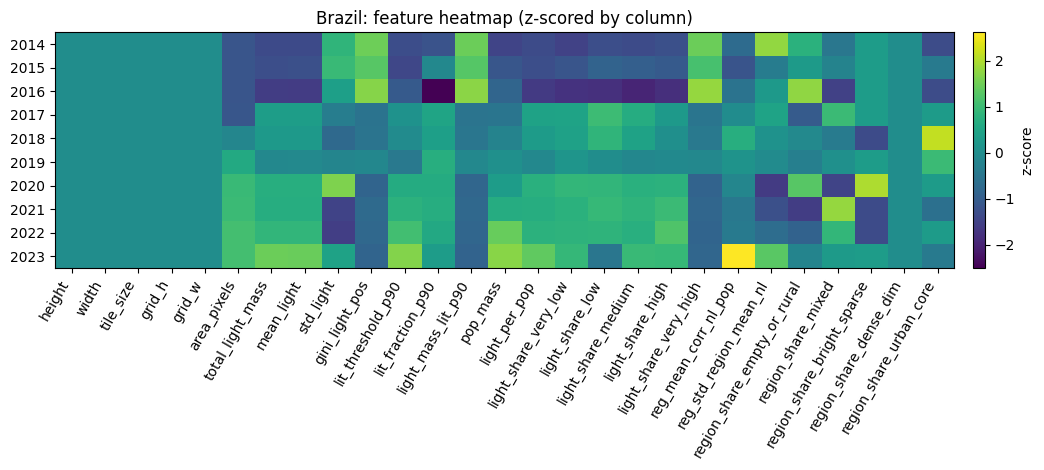

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil\outputs\Brazil_features_heatmap_zscore.png


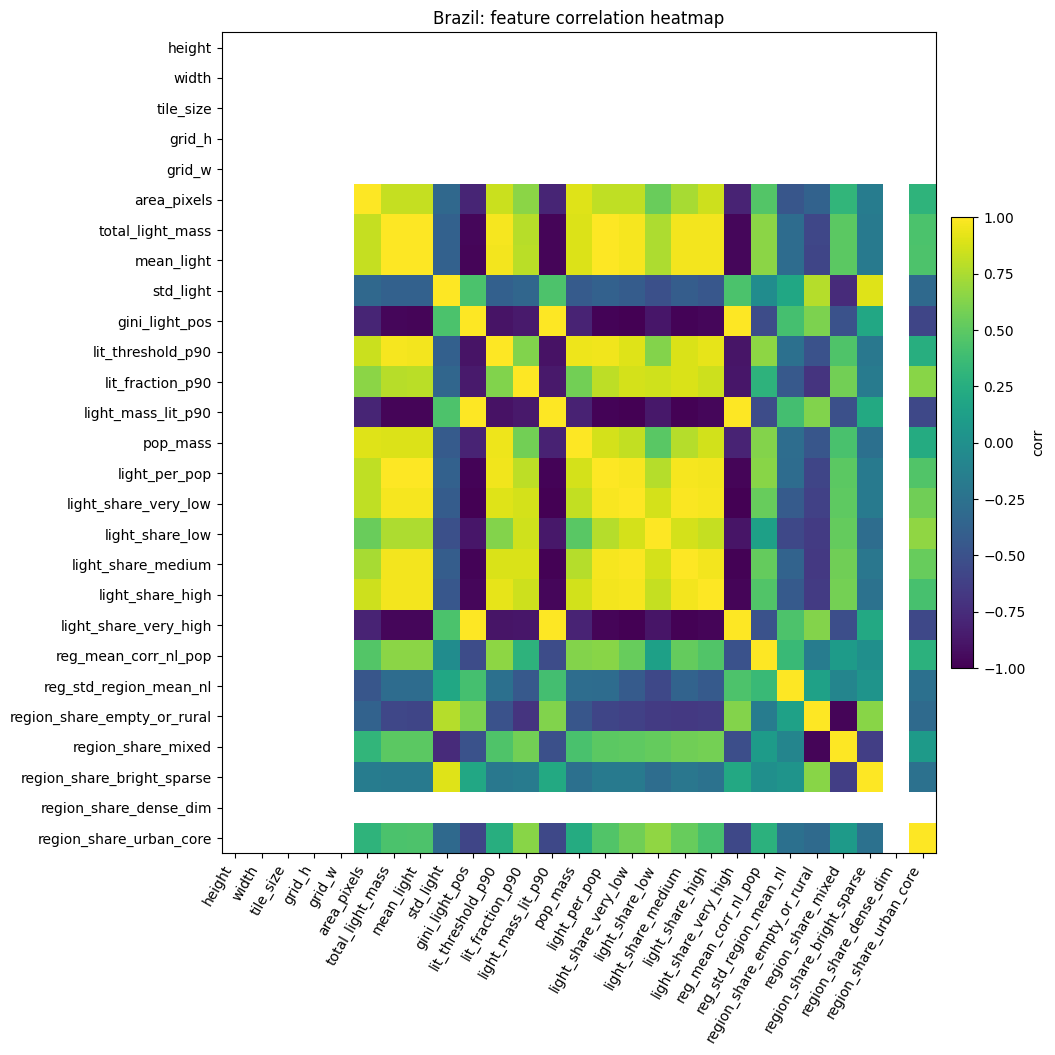

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil\outputs\Brazil_features_correlation_heatmap.png


In [8]:
# === Brazil: heatmaps to explain extracted features ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use in-memory table if available; otherwise load from CSV
if 'features_df' in globals() and isinstance(features_df, pd.DataFrame):
    df_hm = features_df.copy()
else:
    df_hm = pd.read_csv(os.path.join(OUTPUT_DIR, 'Brazil_features_country_year.csv'))

# Keep numeric feature columns (exclude identifiers)
id_cols = [c for c in ['country','year','COUNTRY','YEAR'] if c in df_hm.columns]
num_cols = [c for c in df_hm.columns if c not in id_cols and pd.api.types.is_numeric_dtype(df_hm[c])]

# Heatmap 1: z-scored features over time (rows=year, cols=features)
df_plot = df_hm.sort_values('year' if 'year' in df_hm.columns else df_hm.columns[0]).reset_index(drop=True)
X = df_plot[num_cols].to_numpy(dtype=float)
# z-score per feature (column)
mu = np.nanmean(X, axis=0)
sd = np.nanstd(X, axis=0)
sd[sd == 0] = 1.0
Z = (X - mu) / sd

plt.figure(figsize=(min(16, 1.2 + 0.35*len(num_cols)), 4.8))
im = plt.imshow(Z, aspect='auto')
plt.yticks(range(len(df_plot)), df_plot['year'].astype(str).tolist() if 'year' in df_plot.columns else range(len(df_plot)))
plt.xticks(range(len(num_cols)), num_cols, rotation=60, ha='right')
plt.title('Brazil: feature heatmap (z-scored by column)')
plt.colorbar(im, fraction=0.03, pad=0.02, label='z-score')
plt.tight_layout()
out1 = os.path.join(OUTPUT_DIR, 'Brazil_features_heatmap_zscore.png')
plt.savefig(out1, dpi=200, bbox_inches='tight')
plt.show()
print('Saved:', out1)

# Heatmap 2: feature correlation matrix (helps explain redundancy/relationships)
corr = df_plot[num_cols].corr(numeric_only=True)
plt.figure(figsize=(min(14, 1.2 + 0.35*len(num_cols)), min(12, 1.2 + 0.35*len(num_cols))))
im2 = plt.imshow(corr.to_numpy(), aspect='auto', vmin=-1, vmax=1)
plt.xticks(range(len(num_cols)), num_cols, rotation=60, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Brazil: feature correlation heatmap')
plt.colorbar(im2, fraction=0.03, pad=0.02, label='corr')
plt.tight_layout()
out2 = os.path.join(OUTPUT_DIR, 'Brazil_features_correlation_heatmap.png')
plt.savefig(out2, dpi=200, bbox_inches='tight')
plt.show()
print('Saved:', out2)


Brazil years used: 2014 to 2023


C:\Users\BOUCHRA\AppData\Local\Temp\ipykernel_36852\2949911646.py:48: RuntimeWarning: Mean of empty slice
  nl_mean = np.nanmean(nl_stack, axis=0)
C:\Users\BOUCHRA\AppData\Roaming\Python\Python313\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


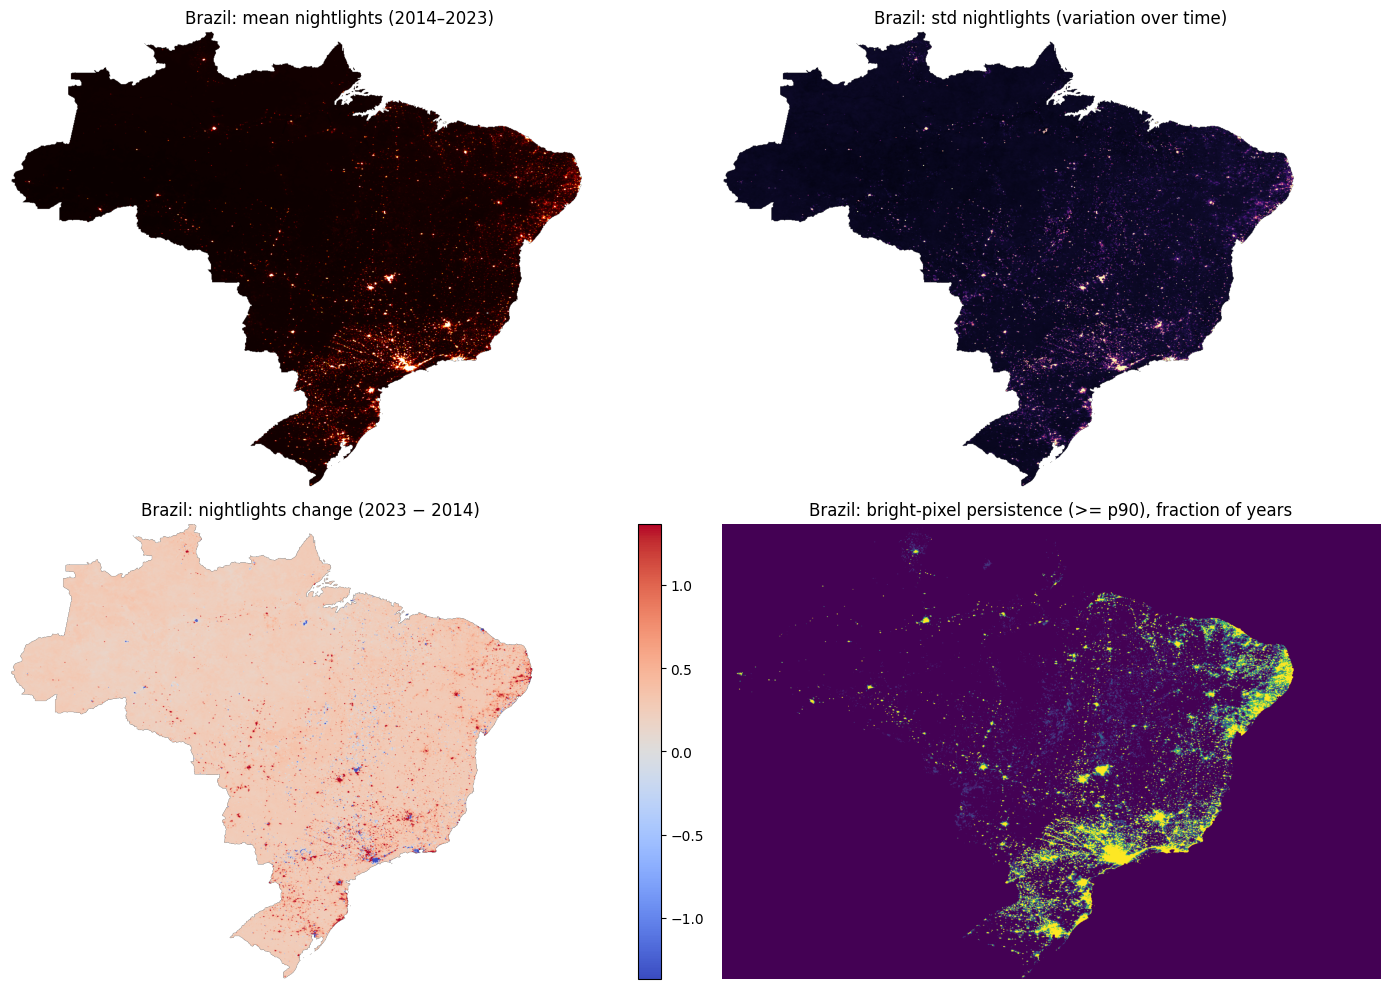

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil\outputs\Brazil_nightlights_summary_maps.png


In [9]:
# === Brazil: additional Morocco-style summary maps (mean / std / change / persistence) ===
import os, re
import numpy as np
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

COUNTRY = 'Brazil'
MAX_DIM = 1200   # reduce to 800 if slow
BAND_NL = 1

def downsample_read(fp, band=1, max_dim=1200, resampling=Resampling.bilinear):
    with rasterio.open(fp) as src:
        h, w = src.height, src.width
        scale = max(h / max_dim, w / max_dim, 1.0)
        out_h, out_w = int(np.ceil(h / scale)), int(np.ceil(w / scale))
        a = src.read(band, out_shape=(out_h, out_w), resampling=resampling, masked=True).astype('float32')
        return np.ma.filled(a, np.nan)

def clip_img(a, p=99.5):
    v = a[np.isfinite(a)]
    if v.size == 0:
        return a
    lo = np.nanmin(v)
    hi = np.percentile(v, p)
    if not np.isfinite(hi) or hi <= lo:
        hi = lo + 1e-6
    return np.clip(a, lo, hi)

# Get Brazil files from existing list 'tifs'
brazil_files = [f for f in tifs if os.path.basename(f).startswith('Brazil_')]
if len(brazil_files) == 0:
    raise FileNotFoundError('No Brazil_*.tif found in tifs. Check your DATA_PATH / folder structure.')

year_to_fp = {}
for fp in brazil_files:
    m = re.findall(r'_(\d{4})', os.path.basename(fp))
    if m:
        year_to_fp[int(m[0])] = fp

years_use = sorted(year_to_fp.keys())
y0, y1 = years_use[0], years_use[-1]
print('Brazil years used:', y0, 'to', y1)

# Stack downsampled nightlights for all years
nl_stack = np.stack([downsample_read(year_to_fp[y], BAND_NL, MAX_DIM) for y in years_use], axis=0)

nl_mean = np.nanmean(nl_stack, axis=0)
nl_std  = np.nanstd(nl_stack, axis=0)
nl_change = downsample_read(year_to_fp[y1], BAND_NL, MAX_DIM) - downsample_read(year_to_fp[y0], BAND_NL, MAX_DIM)

# persistence: fraction of years above overall p90 threshold
v = nl_stack[np.isfinite(nl_stack)]
p90 = np.percentile(v, 90) if v.size else np.nan
nl_persist = np.nanmean(nl_stack >= p90, axis=0) if np.isfinite(p90) else np.full_like(nl_mean, np.nan)

# plot 2x2
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

ax[0,0].imshow(clip_img(nl_mean), cmap='hot', aspect='auto')
ax[0,0].set_title(f'Brazil: mean nightlights ({y0}–{y1})')
ax[0,0].axis('off')

ax[0,1].imshow(clip_img(nl_std), cmap='magma', aspect='auto')
ax[0,1].set_title('Brazil: std nightlights (variation over time)')
ax[0,1].axis('off')

chg = nl_change[np.isfinite(nl_change)]
lim = np.percentile(np.abs(chg), 99) if chg.size else 1.0
lim = lim if np.isfinite(lim) and lim > 0 else 1.0
im = ax[1,0].imshow(np.clip(nl_change, -lim, lim), cmap='coolwarm', aspect='auto')
ax[1,0].set_title(f'Brazil: nightlights change ({y1} − {y0})')
ax[1,0].axis('off')
plt.colorbar(im, ax=ax[1,0], fraction=0.046, pad=0.04)

ax[1,1].imshow(nl_persist, cmap='viridis', vmin=0, vmax=1, aspect='auto')
ax[1,1].set_title('Brazil: bright-pixel persistence (>= p90), fraction of years')
ax[1,1].axis('off')

plt.tight_layout()
out = os.path.join(OUTPUT_DIR, 'Brazil_nightlights_summary_maps.png')
plt.savefig(out, dpi=200, bbox_inches='tight')
plt.show()
print('Saved:', out)


Brazil years used: 2014 to 2023


C:\Users\BOUCHRA\AppData\Local\Temp\ipykernel_36852\4131930769.py:56: RuntimeWarning: Mean of empty slice
  nl_mean = np.nanmean(nl_stack, axis=0)


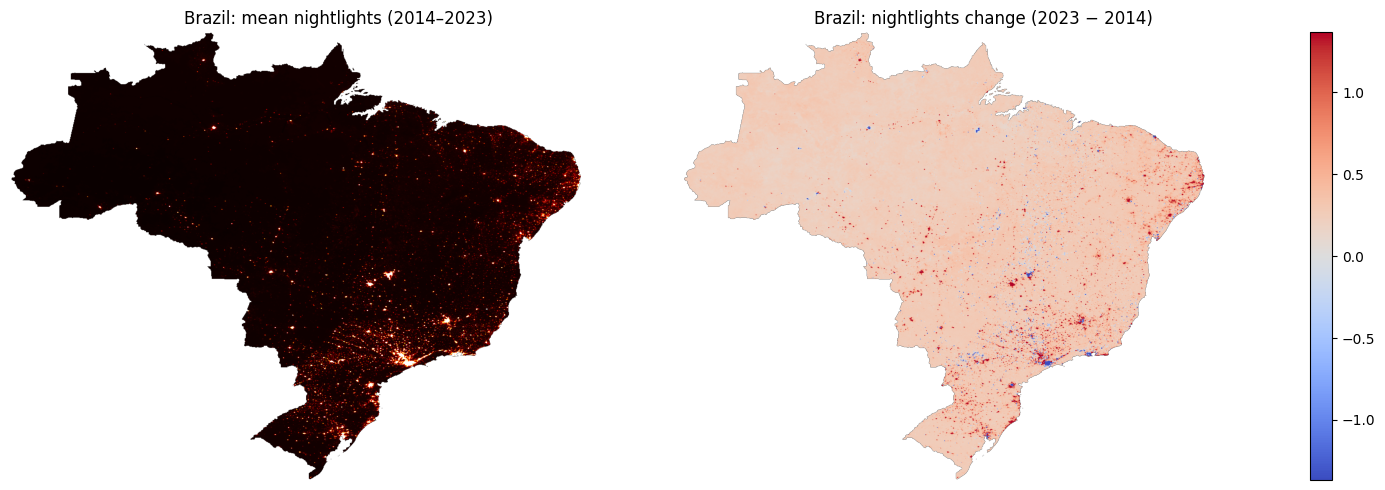

Saved: C:\Users\BOUCHRA\Desktop\stats201_project\STATS201_Week5_Images\Brazil\outputs\Brazil_mean_and_change_nightlights.png


In [10]:
# === Brazil: mean + change nightlights maps (robust & FAST) ===
import os, re
import numpy as np
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

COUNTRY = "Brazil"
BAND_NL = 1
MAX_DIM = 1200  # reduce to 800 if slow

# --- get Brazil files + years directly ---
brazil_files = [f for f in tifs if os.path.basename(f).startswith("Brazil_")]
years_available = sorted(
    int(re.search(r"_(\d{4})", os.path.basename(f)).group(1))
    for f in brazil_files
)

y0, y1 = years_available[0], years_available[-1]
print("Brazil years used:", y0, "to", y1)

year_to_fp = {
    int(re.search(r"_(\d{4})", os.path.basename(f)).group(1)): f
    for f in brazil_files
}

def read_nl_downsample(fp, max_dim=1200):
    with rasterio.open(fp) as src:
        h, w = src.height, src.width
        scale = max(h / max_dim, w / max_dim, 1.0)
        out_h, out_w = int(np.ceil(h / scale)), int(np.ceil(w / scale))
        a = src.read(
            BAND_NL,
            out_shape=(out_h, out_w),
            resampling=Resampling.bilinear,
            masked=True
        ).astype("float32")
        return np.ma.filled(a, np.nan)

def clip_img(a, p=99.5):
    v = a[np.isfinite(a)]
    if v.size == 0:
        return a
    hi = np.percentile(v, p)
    lo = np.nanmin(v)
    if not np.isfinite(hi) or hi <= lo:
        hi = lo + 1e-6
    return np.clip(a, lo, hi)

# --- compute maps ---
nl_stack = np.stack(
    [read_nl_downsample(year_to_fp[y], MAX_DIM) for y in years_available],
    axis=0
)

nl_mean = np.nanmean(nl_stack, axis=0)
nl_change = (
    read_nl_downsample(year_to_fp[y1], MAX_DIM)
    - read_nl_downsample(year_to_fp[y0], MAX_DIM)
)

# --- plot ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].imshow(clip_img(nl_mean), cmap="hot", aspect="auto")
ax[0].set_title(f"Brazil: mean nightlights ({y0}–{y1})")
ax[0].axis("off")

chg = nl_change[np.isfinite(nl_change)]
lim = np.percentile(np.abs(chg), 99) if chg.size else 1.0

im = ax[1].imshow(np.clip(nl_change, -lim, lim),
                  cmap="coolwarm", aspect="auto")
ax[1].set_title(f"Brazil: nightlights change ({y1} − {y0})")
ax[1].axis("off")
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

plt.tight_layout()
out = os.path.join(OUTPUT_DIR, "Brazil_mean_and_change_nightlights.png")
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", out)